In [ ]:
from utils.config import Project_Config, CIFAR_10_Config, CIFAR_10_Local_Config
from utils.custom_enums import Dataset_Type_Enum
project_config = Project_Config()

#CIFAR 2
#Roughly 10 min without CUDA
#Roughly 30 seconds with CUDA

#CIFAR10
# Roughly 1h 40 min without CUDA
# Roughly 5 min with CUDA

In [12]:
dataset_type = Dataset_Type_Enum.CIFAR10
SAVE=True
f = project_config.folder_symbol
save_path = (
    project_config.PWD + f +
    "DINO" + f +
    f"dino-{dataset_type}.pt"
)

In [13]:
if dataset_type == Dataset_Type_Enum.CIFAR2:
    dataset_config = CIFAR_10_Local_Config(
        project_config=project_config,
        dataset_type=dataset_type
    )
if dataset_type == Dataset_Type_Enum.CIFAR10:
    dataset_config = CIFAR_10_Config()

In [14]:
dataset_config.dataset.features

{'image': Image(mode=None, decode=True, id=None),
 'label_txt': Value(dtype='string', id=None)}

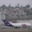

In [15]:
dataset_config.dataset[0]["image"]

In [16]:
dataset_config.dataset[0]["label_txt"]

'airplane'

In [17]:
from transformers import AutoImageProcessor, Dinov2Model

import torch

image = dataset_config.dataset[0]["image"]

image_processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")

model = Dinov2Model.from_pretrained("facebook/dinov2-base")

dataset_size = len(dataset_config.dataset)

if SAVE:

    set_size = 1000
    last_hidden_states = torch.zeros(dataset_size,257,768)
    if project_config.IS_CUDA:
        GPU_BUFFER_SIZE = 5000
        last_hidden_states_buffer = torch.zeros(GPU_BUFFER_SIZE,257,768, device='cuda')
        model.to('cuda')
        buffer_internal_index = 0
        buffer_external_index = 0

    for i in range(0,dataset_size//set_size):
        a=i*set_size
        b=(i+1)*set_size

        input_set = image_processor(dataset_config.dataset[a:b]["image"], return_tensors="pt")

        if project_config.IS_CUDA:
            input_set.to('cuda')

        with torch.no_grad():
            outputs = model(**input_set)

        if project_config.IS_CUDA:
            last_hidden_states_buffer[buffer_internal_index:(buffer_internal_index+set_size)] = outputs.last_hidden_state
            buffer_internal_index += set_size
            if buffer_internal_index == GPU_BUFFER_SIZE:
                last_hidden_states[buffer_external_index:(buffer_external_index+GPU_BUFFER_SIZE)] = last_hidden_states_buffer.detach().cpu()
                last_hidden_states_buffer = torch.zeros_like(last_hidden_states_buffer, device='cuda')
                buffer_external_index += GPU_BUFFER_SIZE
                buffer_internal_index = 0
        else:
            last_hidden_states[a:b] = outputs.last_hidden_state
        print(f"Completed {(i+1)*set_size} of {dataset_size} images")

    print(list(last_hidden_states.shape))

    torch.save(last_hidden_states, save_path)

Completed 1000 of 50000 images
Completed 2000 of 50000 images
Completed 3000 of 50000 images
Completed 4000 of 50000 images
Completed 5000 of 50000 images
Completed 6000 of 50000 images
Completed 7000 of 50000 images
Completed 8000 of 50000 images
Completed 9000 of 50000 images
Completed 10000 of 50000 images
Completed 11000 of 50000 images
Completed 12000 of 50000 images
Completed 13000 of 50000 images
Completed 14000 of 50000 images
Completed 15000 of 50000 images
Completed 16000 of 50000 images
Completed 17000 of 50000 images
Completed 18000 of 50000 images
Completed 19000 of 50000 images
Completed 20000 of 50000 images
Completed 21000 of 50000 images
Completed 22000 of 50000 images
Completed 23000 of 50000 images
Completed 24000 of 50000 images
Completed 25000 of 50000 images
Completed 26000 of 50000 images
Completed 27000 of 50000 images
Completed 28000 of 50000 images
Completed 29000 of 50000 images
Completed 30000 of 50000 images
Completed 31000 of 50000 images
Completed 32000 o

In [18]:
pregenerated_dino_results = torch.load(save_path)
print(list(pregenerated_dino_results.shape))

pregenerated_dino_results = pregenerated_dino_results.reshape(dataset_size,257*768)

/tmp/ipykernel_451320/3449114581.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pregenerated_dino_results = torch.load(save_path)


[50000, 257, 768]


In [19]:
image = dataset_config.dataset[100]["image"]
input_image = image_processor(image, return_tensors="pt")

if project_config.IS_CUDA:
    input_image.to('cuda')

with torch.no_grad():
    outputs = model(**input_image)

last_hidden_state = outputs.last_hidden_state.detach().cpu()

last_hidden_state = last_hidden_state.reshape(1,257*768)

print(last_hidden_state.shape)
print(pregenerated_dino_results.shape)

cosine_similarity = torch.nn.CosineSimilarity(dim=1)

c = torch.zeros(1,dataset_size)

set_size = 1000

for i in range(0,dataset_size//set_size):
    a=i*set_size
    b=(i+1)*set_size

    c[0,a:b] = cosine_similarity(last_hidden_state,pregenerated_dino_results[a:b])

print(c.shape)
print(c)
print(torch.argmax(c))

torch.Size([1, 197376])
torch.Size([50000, 197376])
torch.Size([1, 50000])
tensor([[0.0533, 0.2341, 0.0879,  ..., 0.0890, 0.0982, 0.1085]])
tensor(100)


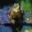

In [21]:
display(dataset_config.dataset[100]["image"])

tensor([  100, 29092, 31090, 14660, 42653, 13771, 20238, 22508, 45898,  4564])


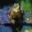

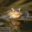

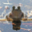

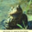

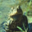

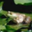

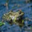

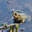

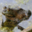

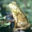

In [20]:
best_matches = torch.flatten(torch.topk(c,10).indices)
print(best_matches)

for i in range(10):
    display(dataset_config.dataset["image"][best_matches[i]])